In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random


c:\Users\Semykin\anaconda3\envs\pars\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)


In [3]:
directory =  "D:\Lab Python\dataset_3"   
# test_dir = "D:\Lab Python\Lab_1\dataset\ rose" 
   
directory_list = glob.glob((os.path.join(directory, "*.jpeg")))
print(len(directory_list))

train_list, test_list = train_test_split(directory_list, test_size = 0.1)
train_list, val_list = train_test_split(train_list, test_size = 0.1111)

print("train", len(train_list))
print("test", len(test_list))
print("val", len(val_list))

2316
train 1852
test 232
val 232


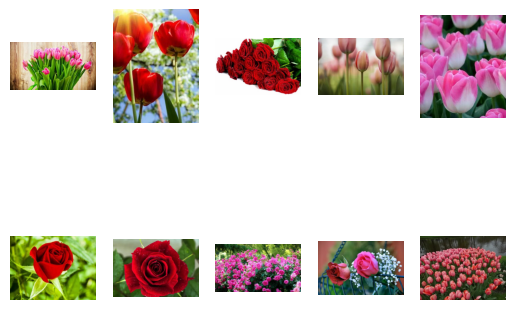

In [4]:
random_idx = np.random.randint(1, len(train_list), size = 10)
fig = plt.figure()
i = 1

for idx in random_idx:
    ax = fig.add_subplot(2, 5, i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i += 1
    plt.axis('off')
    plt.tick_params(axis = 'both', left = False, top = False, right = False, bottom = False,
                    labelleft = False, labeltop = False, labelright = False, labelbottom = False)
    plt.savefig('foo.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.0)

plt.show()


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.Grayscale(),
    transforms.ToTensor(), ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.Grayscale(),
    transforms.ToTensor(), ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.Grayscale(),
    transforms.ToTensor()])

class Init_selection(Dataset):
    def __init__(self, file_list, transform = None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)

        return self.filelength

    def __getitem__(self, id):
        img_path = self.file_list[id]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        num = int(img_path.split('.')[1])


        if label == 'rose':
            label = 0
        elif label == 'tulip':
            label = 1
            
        return img_transformed, label, num

train_data = Init_selection(train_list, transform = train_transforms)
test_data = Init_selection(test_list, transform = test_transforms)
val_data = Init_selection(val_list, transform = test_transforms)

In [6]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding = 0, stride = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 3, padding = 0, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 0, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.fc1 = nn.Linear(3*3*64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

model = Cnn().to(device)
model.train()


Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [7]:

# optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
# criterion = nn.CrossEntropyLoss()

def train_loop(train_loader, val_loader, epochs, lr):
    optimizer = optim.Adam(params = model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    
    val_loss_list = []
    val_accuracy_list = []
    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label, i in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim = 1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
            epoch+1, epoch_accuracy, epoch_loss))

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0

            for data, label, i in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)

            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

    num_epochs = [i + 1 for i in range(epochs)]

    fig = plt.figure(figsize = (30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1, 2, 1)
    plt.plot(num_epochs, loss_list, label = 'loss', color = "r")
    plt.legend(loc = 2, prop = {'size': 20})
    fig.add_subplot(1, 2, 2)
    plt.plot(num_epochs, accuracy_list, label = 'accuracy', color = "g")
    plt.legend(loc = 2, prop = {'size': 20})

    fig = plt.figure(figsize = (30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1, 2, 1)
    plt.plot(num_epochs, val_loss_list, label = "loss", color = "r")
    plt.legend(loc = 2, prop = {'size': 20})
    fig.add_subplot(1, 2, 2)
    plt.plot(num_epochs, val_accuracy_list, label = "accuracy", color = "g") 
    plt.legend(loc = 2, prop = {'size': 20})
    plt.xlim(1, epochs)
    plt.ylim(0, 1)


Epoch : 1, train accuracy : 0.8912955522537231, train loss : 0.25184643268585205
Epoch : 1, val_accuracy : 0.831250011920929, val_loss : 0.36735057830810547
Epoch : 2, train accuracy : 0.8928340077400208, train loss : 0.24613237380981445
Epoch : 2, val_accuracy : 0.8708333969116211, val_loss : 0.27156686782836914
Epoch : 3, train accuracy : 0.908501923084259, train loss : 0.2380276918411255
Epoch : 3, val_accuracy : 0.87541663646698, val_loss : 0.25382477045059204
Epoch : 4, train accuracy : 0.9075708985328674, train loss : 0.2092968374490738
Epoch : 4, val_accuracy : 0.8958333730697632, val_loss : 0.24094046652317047


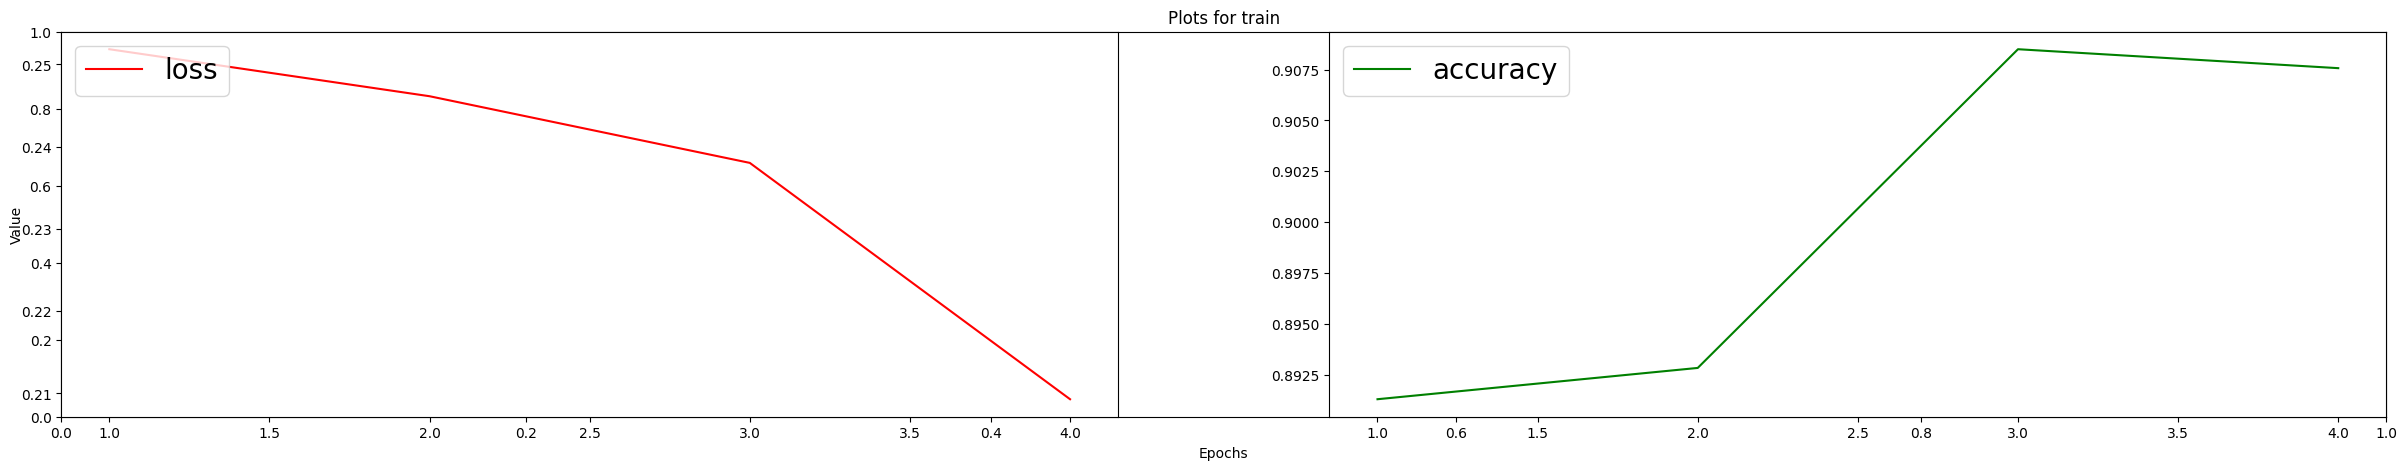

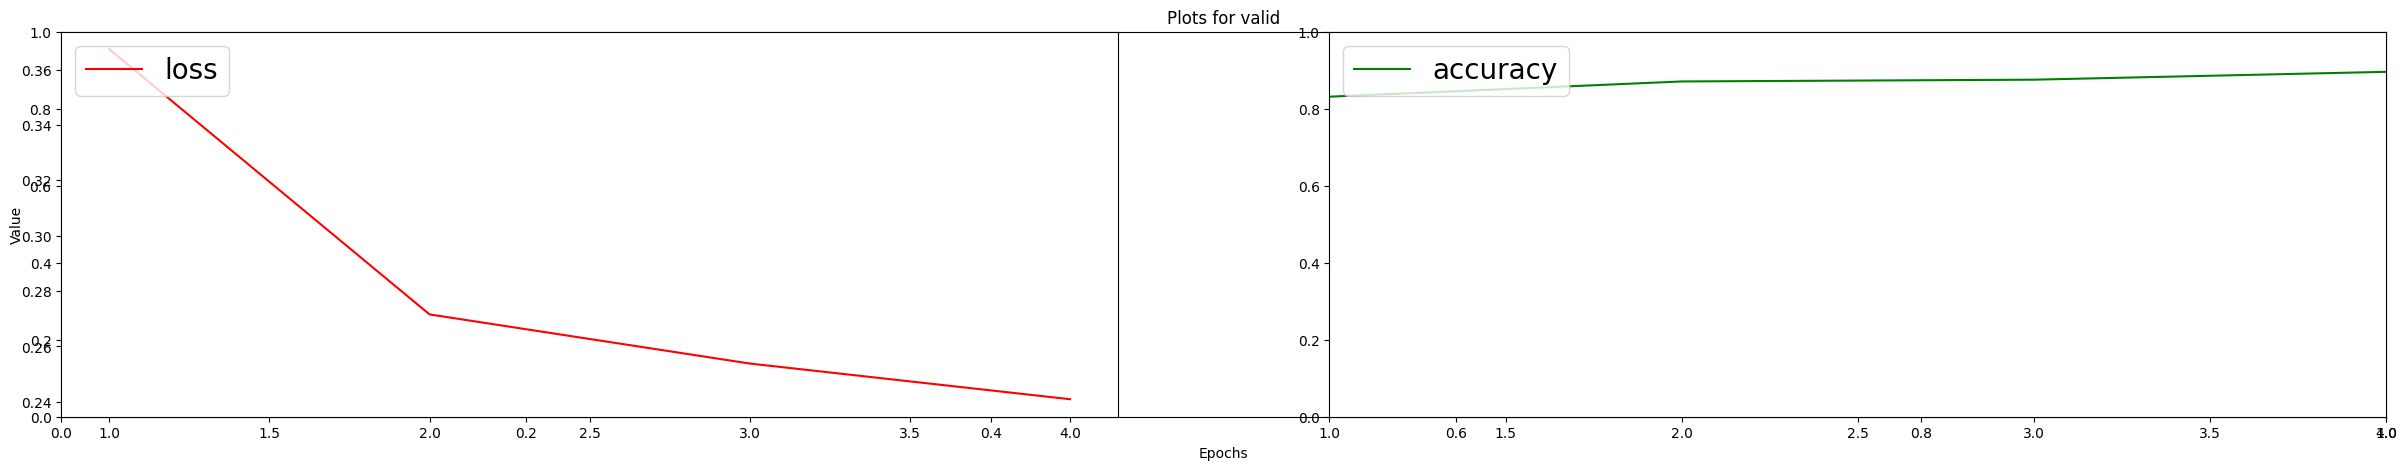

In [76]:
lr = 0.001
epochs = 4
batch_size = 100

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.890728771686554, train loss : 0.24391807615756989
Epoch : 1, val_accuracy : 0.8558333516120911, val_loss : 0.33247700333595276
Epoch : 2, train accuracy : 0.8912551403045654, train loss : 0.25799083709716797
Epoch : 2, val_accuracy : 0.90541672706604, val_loss : 0.22226926684379578
Epoch : 3, train accuracy : 0.8991902470588684, train loss : 0.22775053977966309
Epoch : 3, val_accuracy : 0.8270833492279053, val_loss : 0.3213980197906494
Epoch : 4, train accuracy : 0.895060658454895, train loss : 0.2407929003238678
Epoch : 4, val_accuracy : 0.8725000023841858, val_loss : 0.32297009229660034
Epoch : 5, train accuracy : 0.8961132764816284, train loss : 0.22977951169013977
Epoch : 5, val_accuracy : 0.8854166269302368, val_loss : 0.28810542821884155
Epoch : 6, train accuracy : 0.9117814898490906, train loss : 0.21085502207279205
Epoch : 6, val_accuracy : 0.8891666531562805, val_loss : 0.24482353031635284
Epoch : 7, train accuracy : 0.9102024435997009, train loss

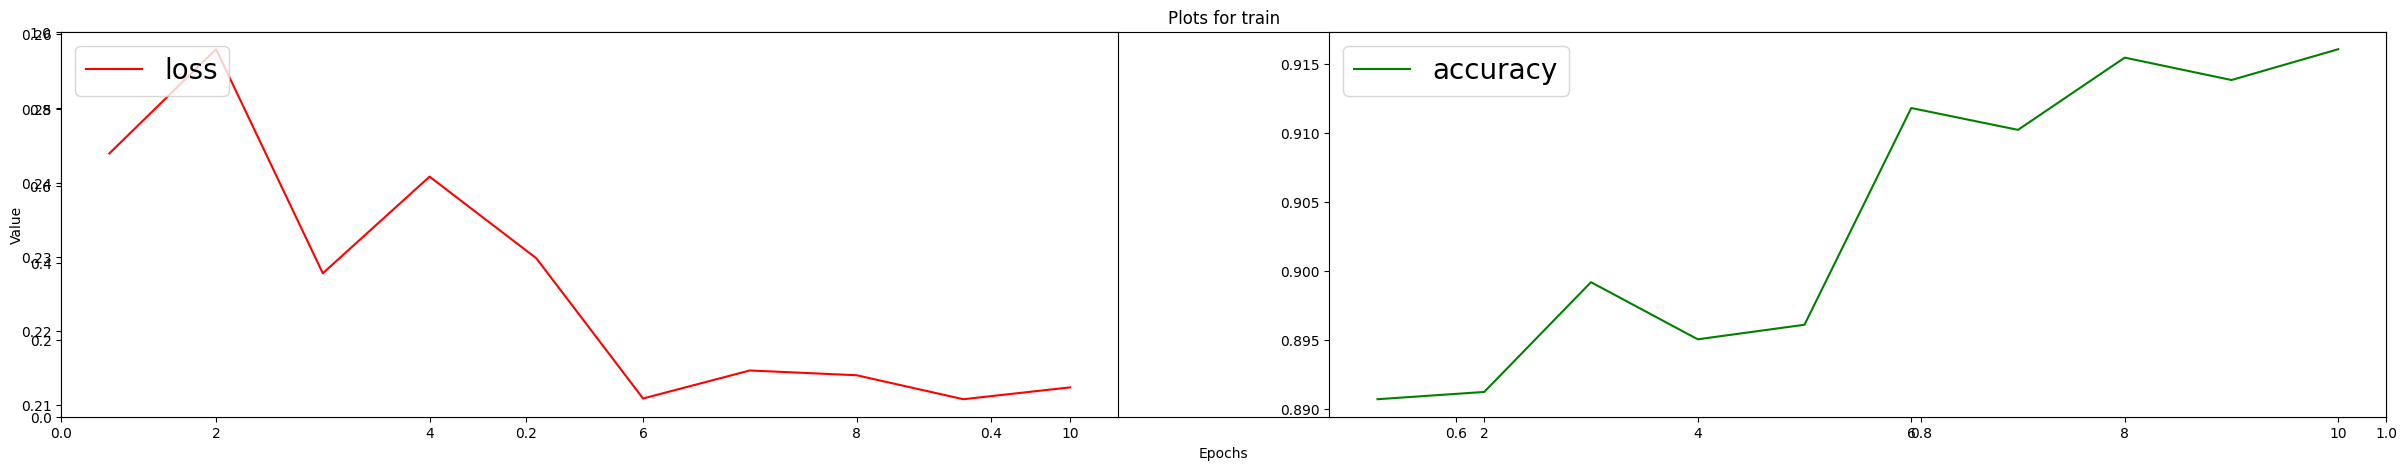

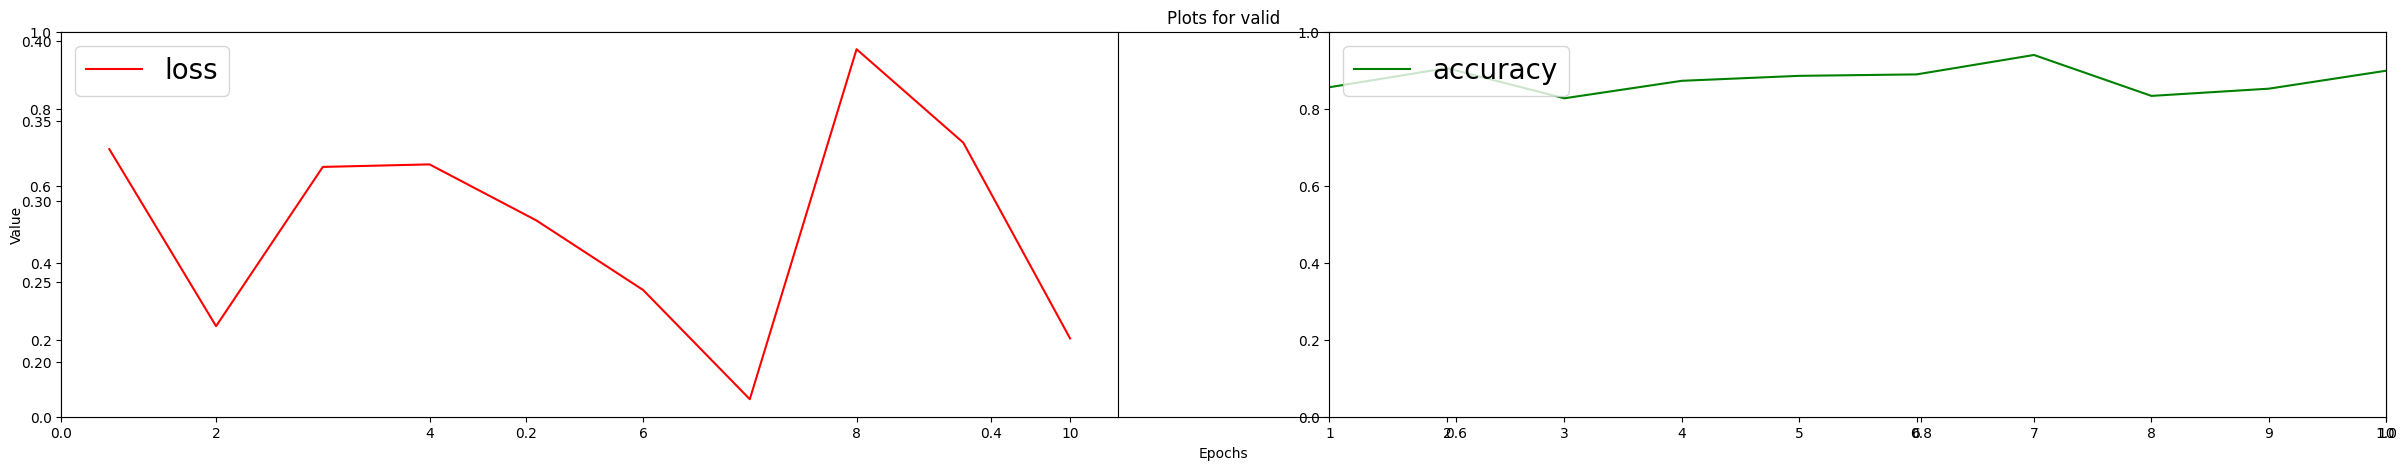

In [77]:
lr = 0.001
epochs = 10
batch_size = 100

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.9185829758644104, train loss : 0.21498608589172363
Epoch : 1, val_accuracy : 0.87541663646698, val_loss : 0.29704388976097107
Epoch : 2, train accuracy : 0.9174493551254272, train loss : 0.2159968465566635
Epoch : 2, val_accuracy : 0.8612499833106995, val_loss : 0.28717130422592163
Epoch : 3, train accuracy : 0.9212549924850464, train loss : 0.1894875466823578
Epoch : 3, val_accuracy : 0.8891666531562805, val_loss : 0.2728802561759949
Epoch : 4, train accuracy : 0.9171254634857178, train loss : 0.20517131686210632
Epoch : 4, val_accuracy : 0.8379166722297668, val_loss : 0.39423778653144836
Epoch : 5, train accuracy : 0.9186234474182129, train loss : 0.20956888794898987
Epoch : 5, val_accuracy : 0.8508332967758179, val_loss : 0.3434915840625763
Epoch : 6, train accuracy : 0.9054655432701111, train loss : 0.2236749678850174
Epoch : 6, val_accuracy : 0.8550000190734863, val_loss : 0.2947045564651489
Epoch : 7, train accuracy : 0.9070444703102112, train loss :

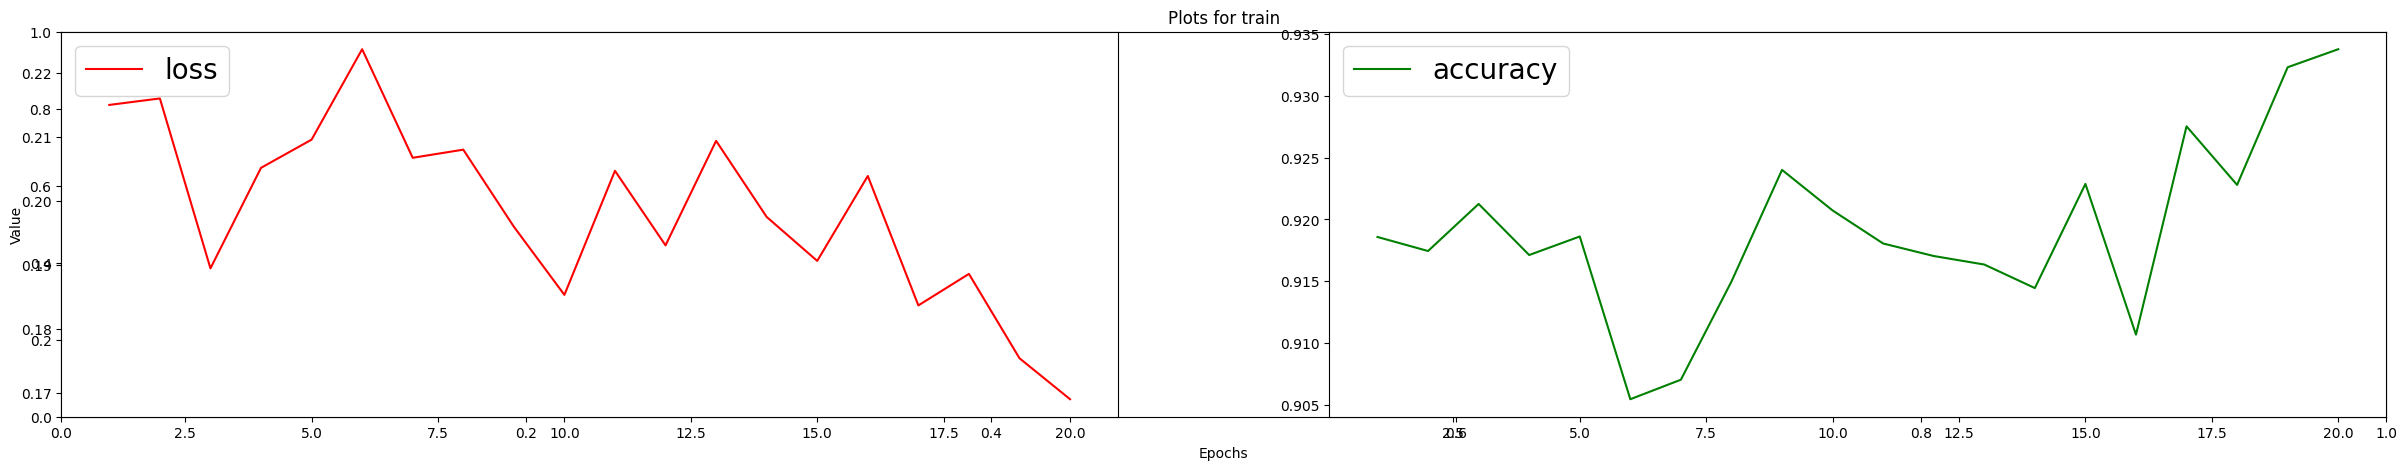

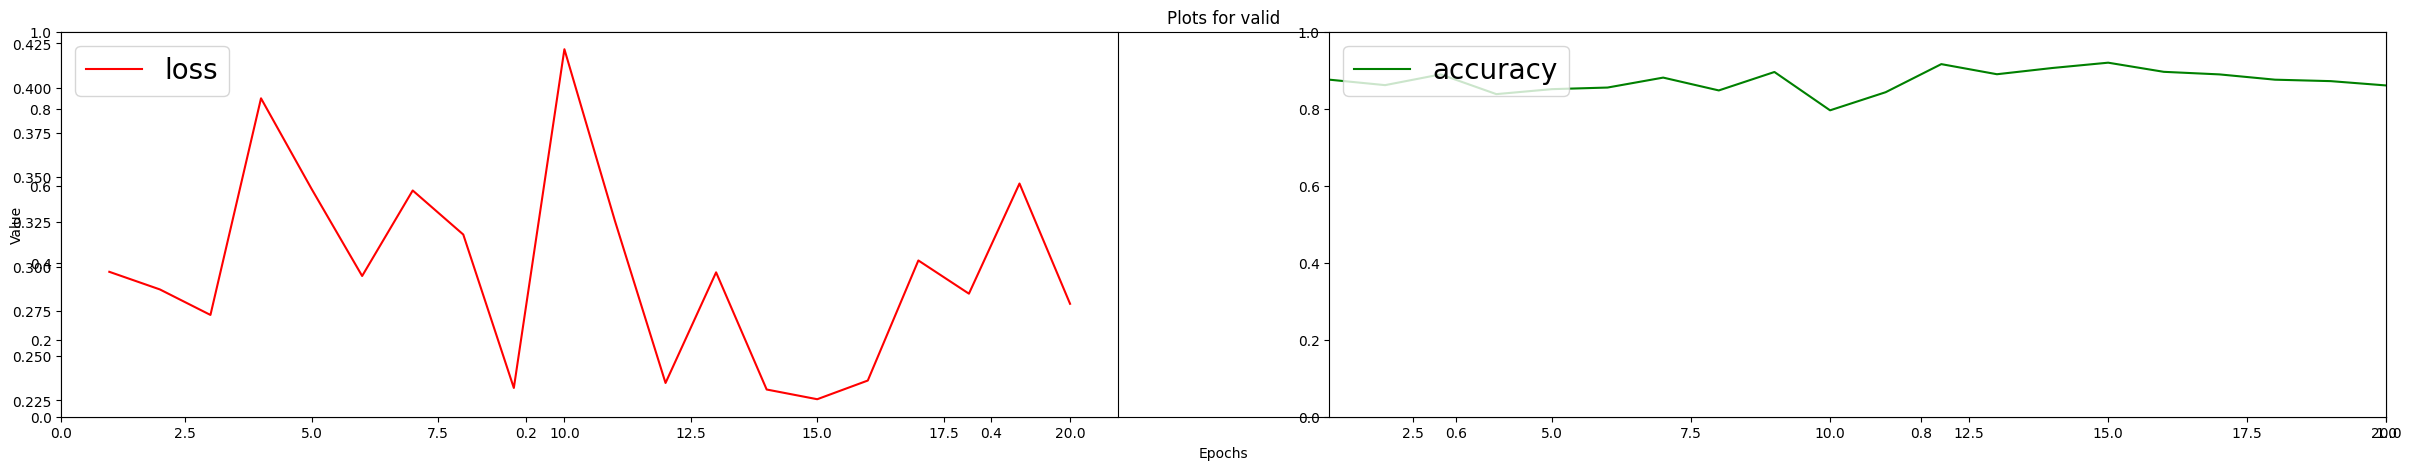

In [79]:
lr = 0.001
epochs = 20
batch_size = 100

train_loader = DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.7946962118148804, train loss : 0.4935501515865326
Epoch : 1, val_accuracy : 0.8316667079925537, val_loss : 0.37987226247787476
Epoch : 2, train accuracy : 0.8520647287368774, train loss : 0.3431956171989441
Epoch : 2, val_accuracy : 0.8474999666213989, val_loss : 0.3461199700832367
Epoch : 3, train accuracy : 0.8466396331787109, train loss : 0.3336818218231201
Epoch : 3, val_accuracy : 0.8399999737739563, val_loss : 0.3663354516029358
Epoch : 4, train accuracy : 0.8680567145347595, train loss : 0.3003200888633728
Epoch : 4, val_accuracy : 0.8579166531562805, val_loss : 0.3116762936115265


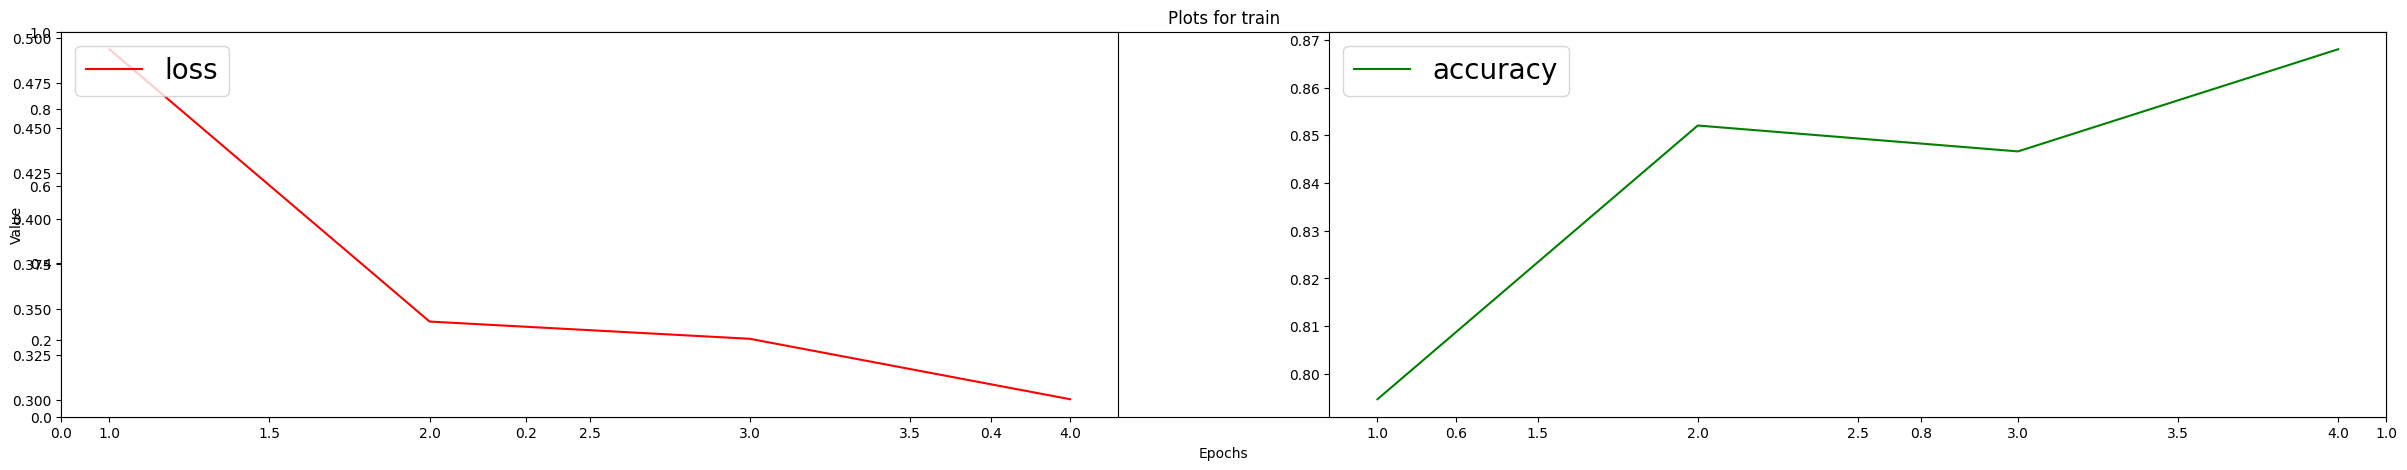

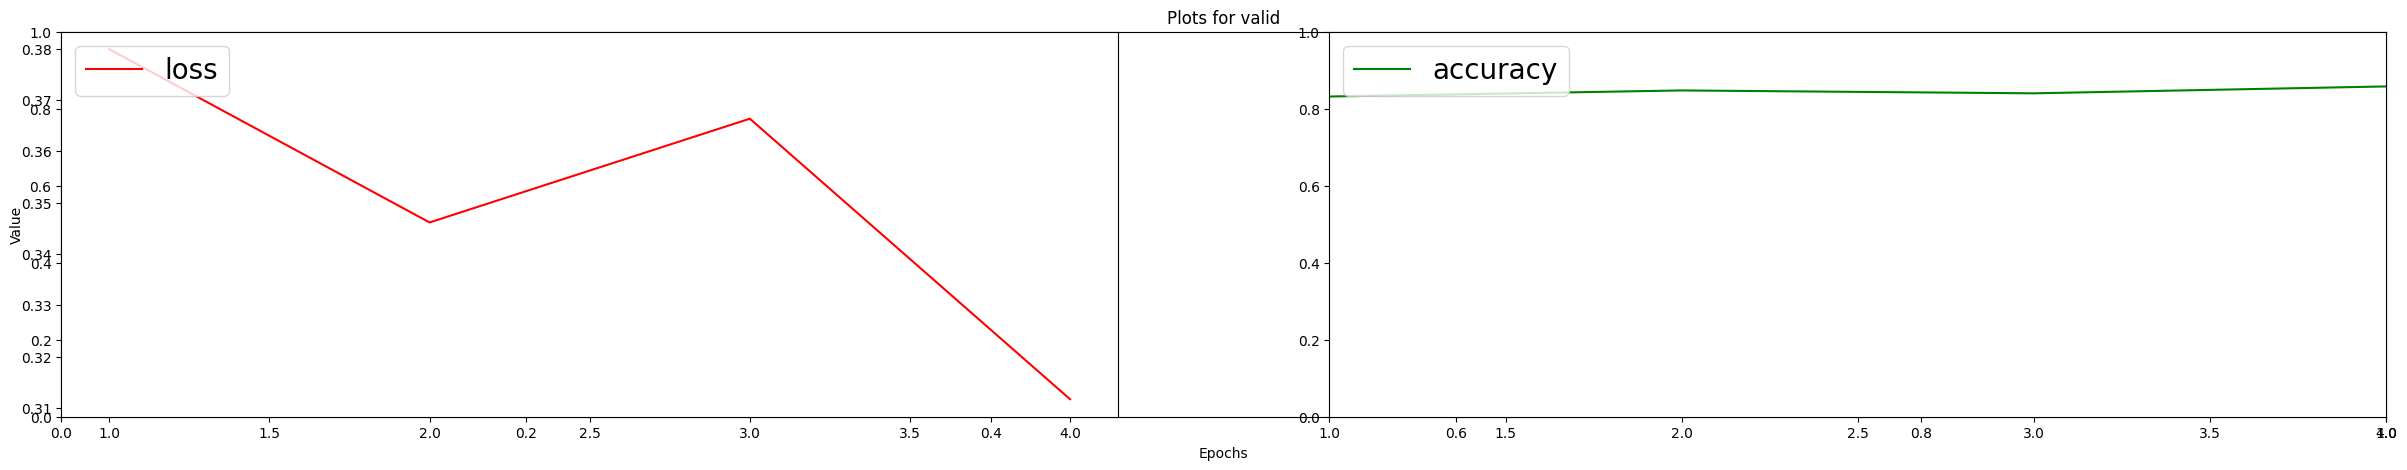

In [80]:
lr = 0.005
epochs = 4
batch_size = 100

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.5507692694664001, train loss : 3.0856666564941406
Epoch : 1, val_accuracy : 0.7066666483879089, val_loss : 0.5882557034492493
Epoch : 2, train accuracy : 0.6643723845481873, train loss : 0.5753968358039856
Epoch : 2, val_accuracy : 0.6191666722297668, val_loss : 0.5905197858810425
Epoch : 3, train accuracy : 0.7215385437011719, train loss : 0.5243139266967773
Epoch : 3, val_accuracy : 0.7066667079925537, val_loss : 0.5673458576202393
Epoch : 4, train accuracy : 0.7273684740066528, train loss : 0.5336399078369141
Epoch : 4, val_accuracy : 0.7291666865348816, val_loss : 0.611912190914154


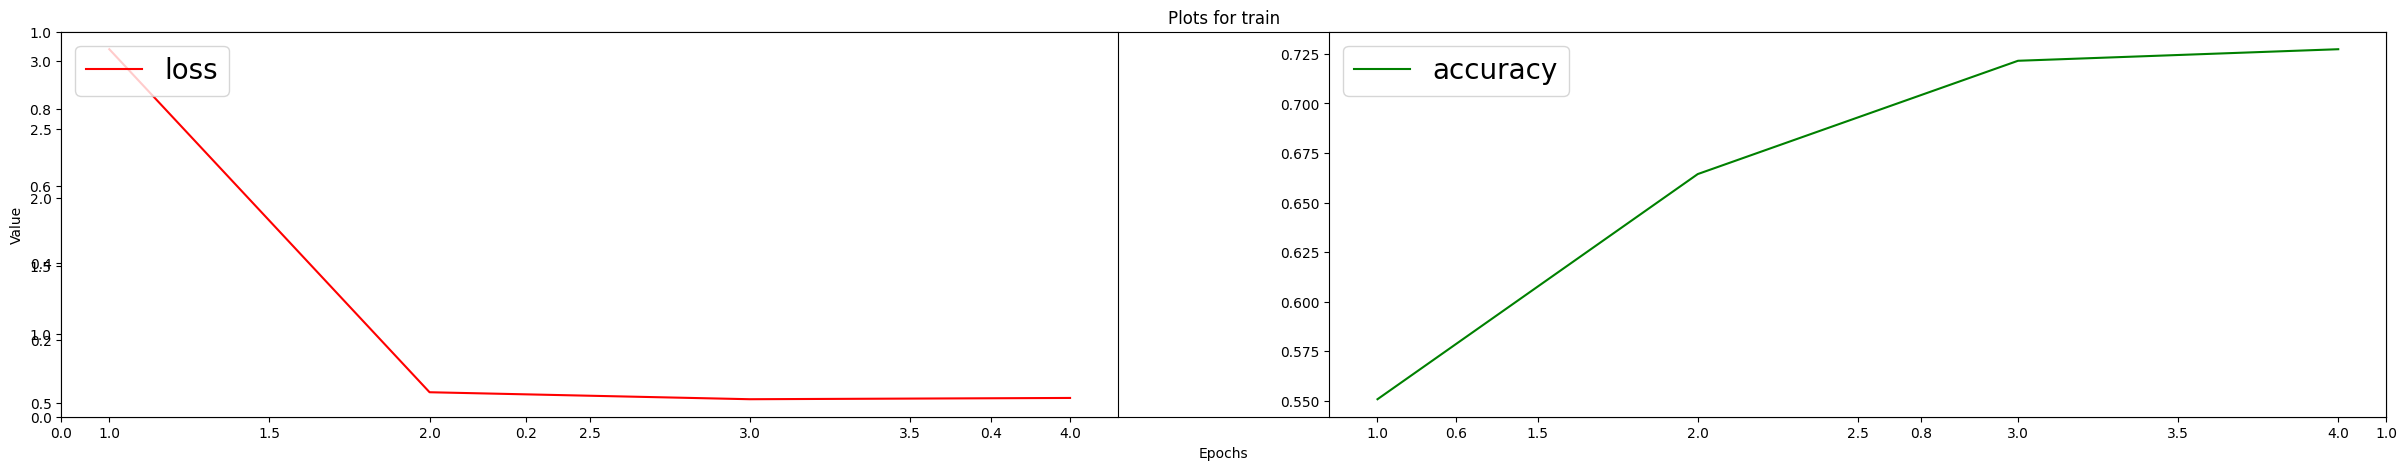

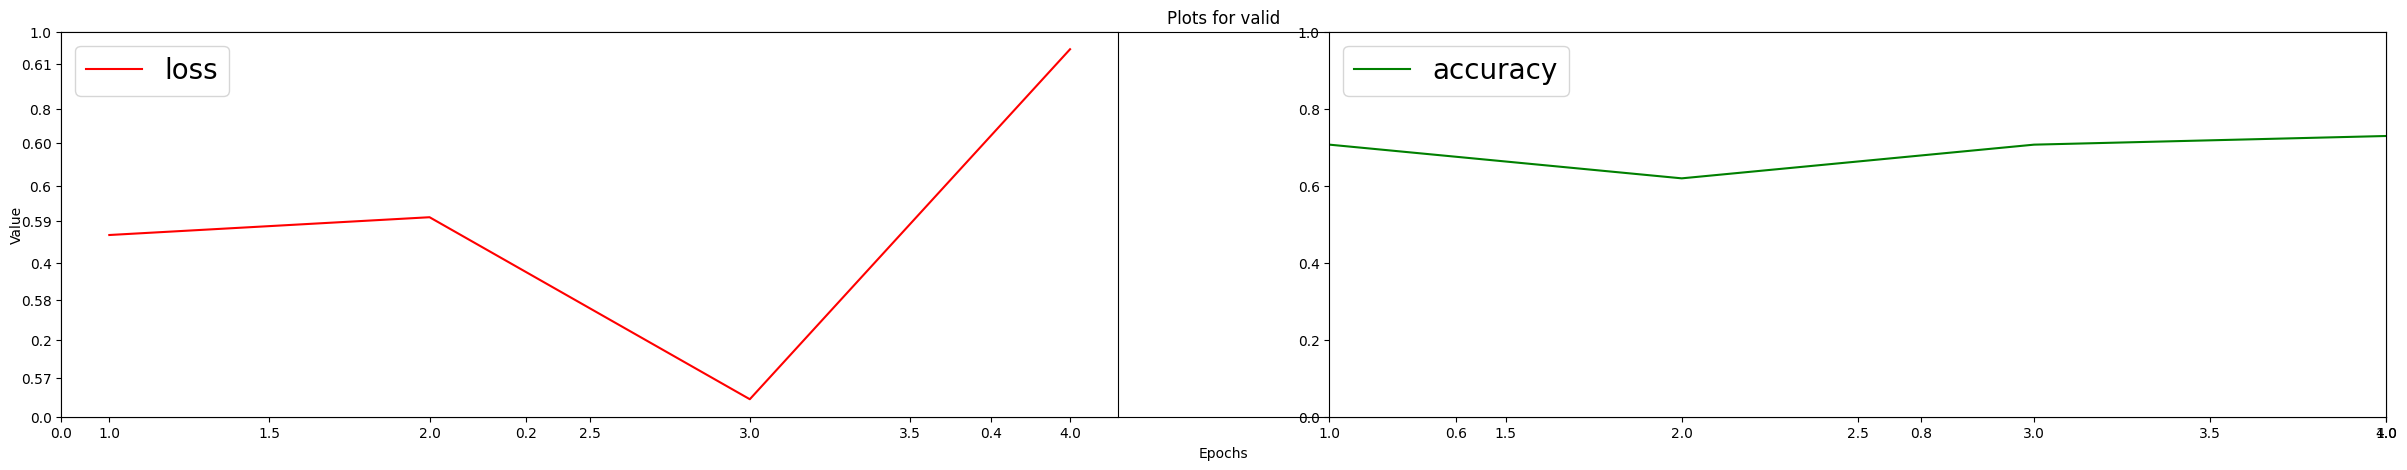

In [81]:
lr = 0.1
epochs = 4
batch_size = 100

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.5231174230575562, train loss : 0.8582450747489929
Epoch : 1, val_accuracy : 0.3695833384990692, val_loss : 0.7259724736213684
Epoch : 2, train accuracy : 0.47603243589401245, train loss : 0.6972231268882751
Epoch : 2, val_accuracy : 0.4404166340827942, val_loss : 0.6991731524467468
Epoch : 3, train accuracy : 0.5072874426841736, train loss : 0.696198582649231
Epoch : 3, val_accuracy : 0.419166624546051, val_loss : 0.7044971585273743
Epoch : 4, train accuracy : 0.4943319261074066, train loss : 0.6955305337905884
Epoch : 4, val_accuracy : 0.60916668176651, val_loss : 0.684240996837616


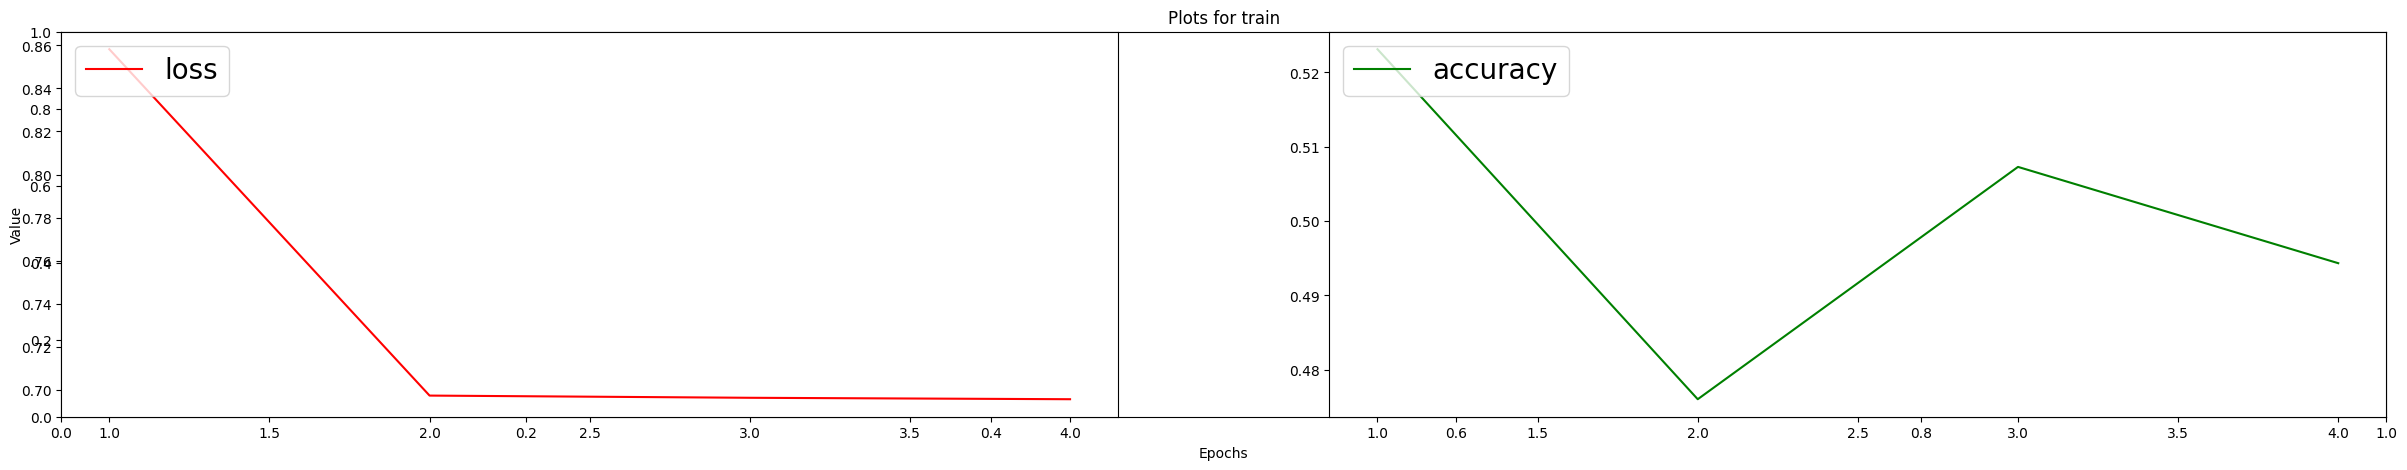

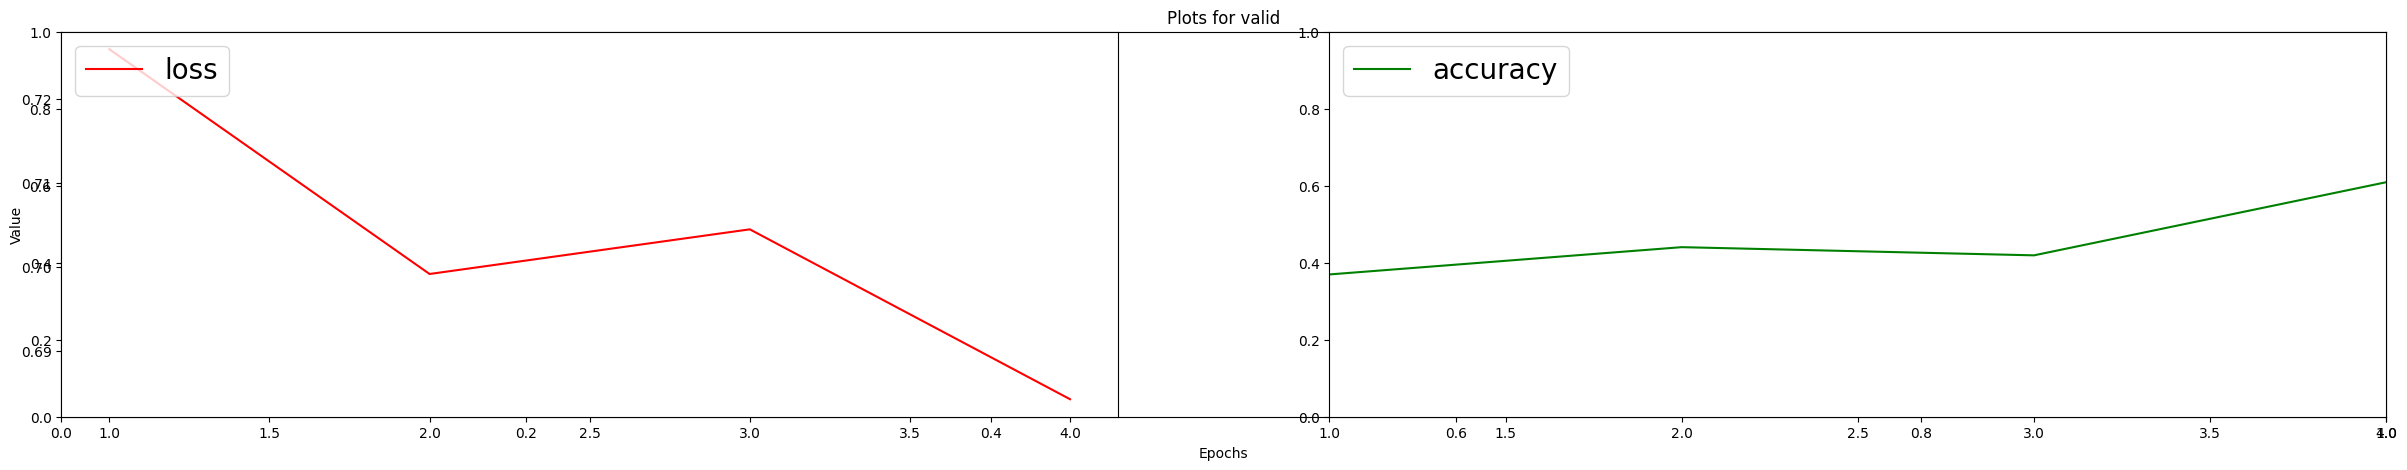

In [82]:
lr = 0.4
epochs = 4
batch_size = 100

train_loader = DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

train_loop(train_loader, val_loader, epochs, lr)


Epoch : 1, train accuracy : 0.48387059569358826, train loss : 0.6943070292472839
Epoch : 1, val_accuracy : 0.4333333671092987, val_loss : 0.6946545839309692
Epoch : 2, train accuracy : 0.5043007135391235, train loss : 0.6930462718009949
Epoch : 2, val_accuracy : 0.4166666865348816, val_loss : 0.6993100047111511
Epoch : 3, train accuracy : 0.5075265169143677, train loss : 0.6932253837585449
Epoch : 3, val_accuracy : 0.40000003576278687, val_loss : 0.7073238492012024
Epoch : 4, train accuracy : 0.5086017847061157, train loss : 0.693261981010437
Epoch : 4, val_accuracy : 0.4333333373069763, val_loss : 0.6959235072135925


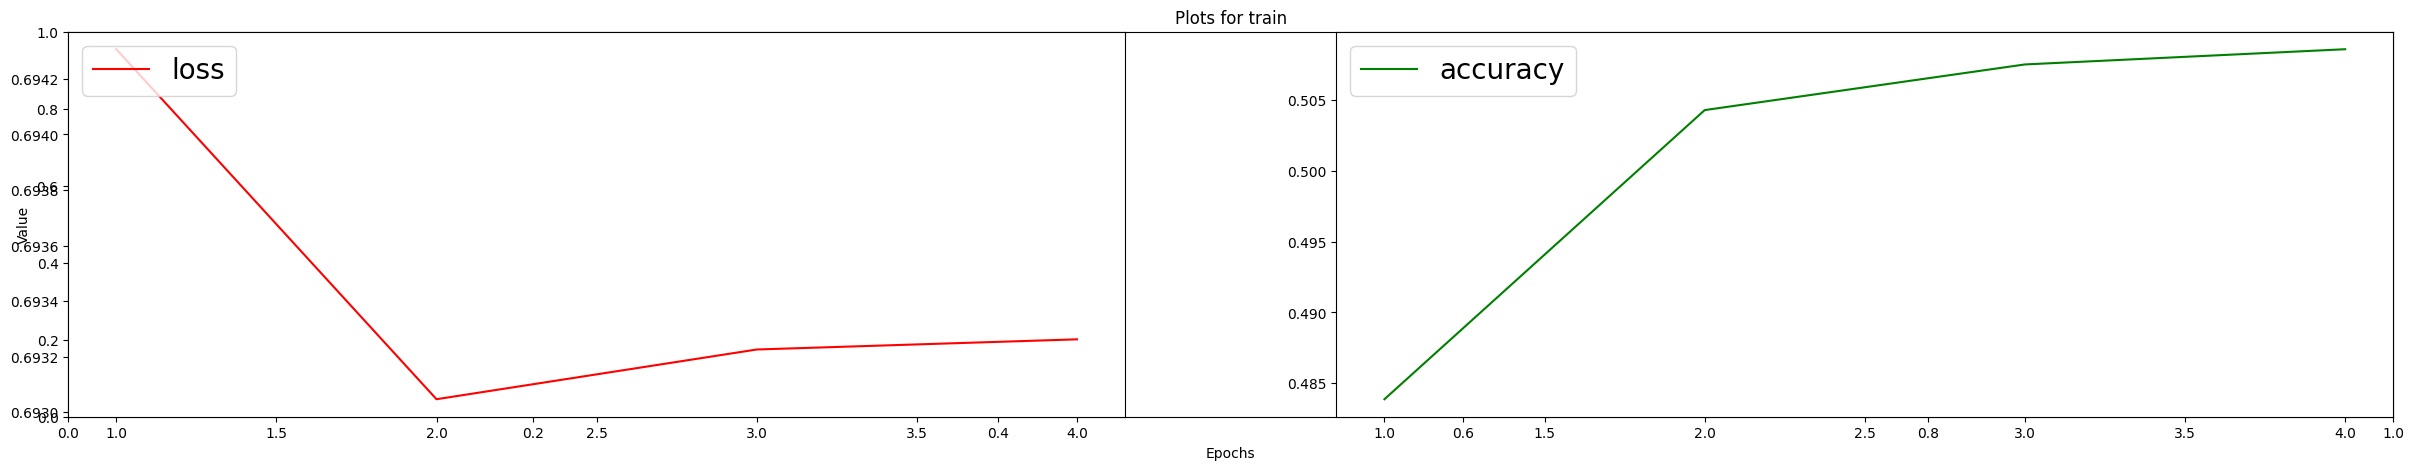

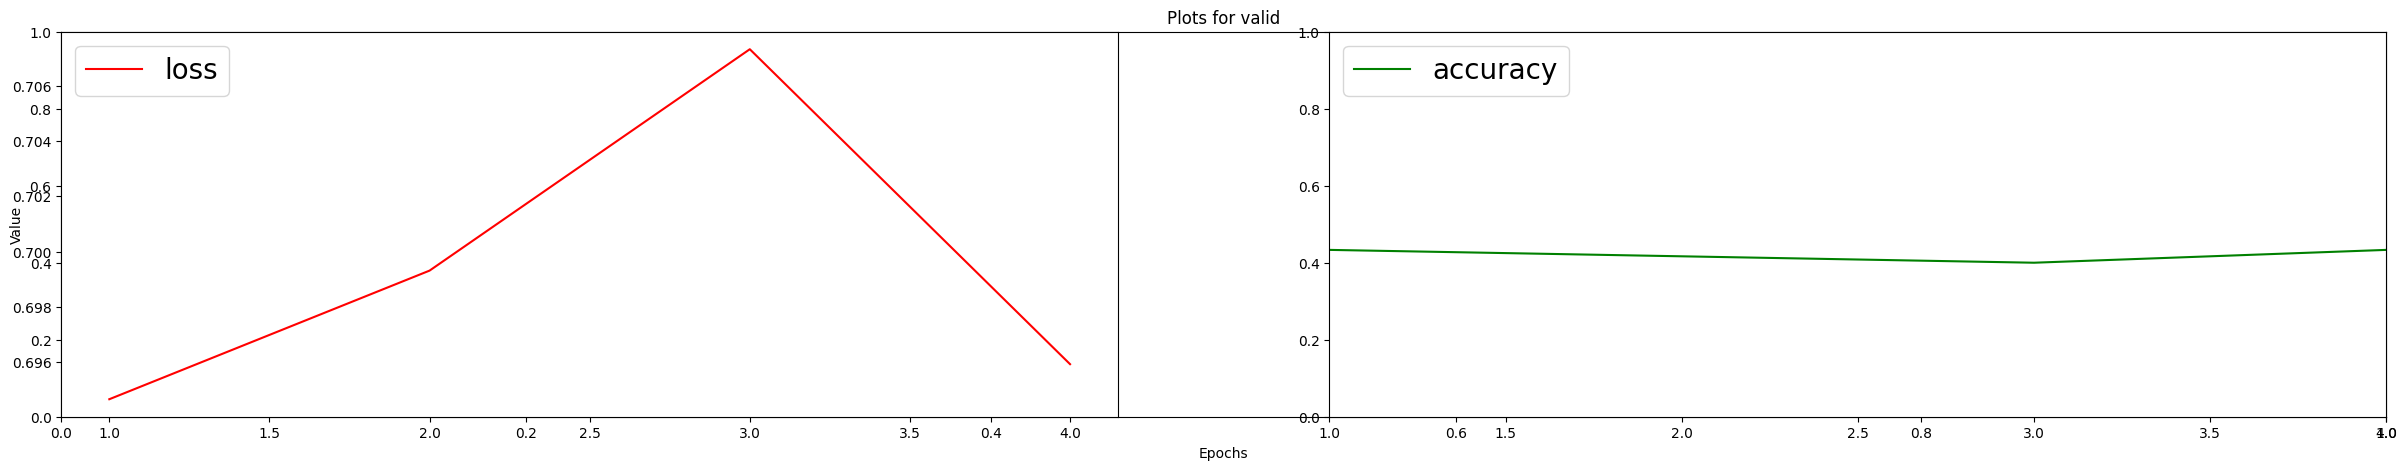

In [83]:
lr = 0.005
epochs = 4
batch_size = 10

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.49157893657684326, train loss : 0.6932918429374695
Epoch : 1, val_accuracy : 0.4154999852180481, val_loss : 0.6977595090866089
Epoch : 2, train accuracy : 0.5000000596046448, train loss : 0.6936535239219666
Epoch : 2, val_accuracy : 0.4065000116825104, val_loss : 0.6975473761558533
Epoch : 3, train accuracy : 0.5126315355300903, train loss : 0.6931530237197876
Epoch : 3, val_accuracy : 0.4244999885559082, val_loss : 0.6951870918273926
Epoch : 4, train accuracy : 0.5126314759254456, train loss : 0.6929938197135925
Epoch : 4, val_accuracy : 0.42000001668930054, val_loss : 0.6973292231559753


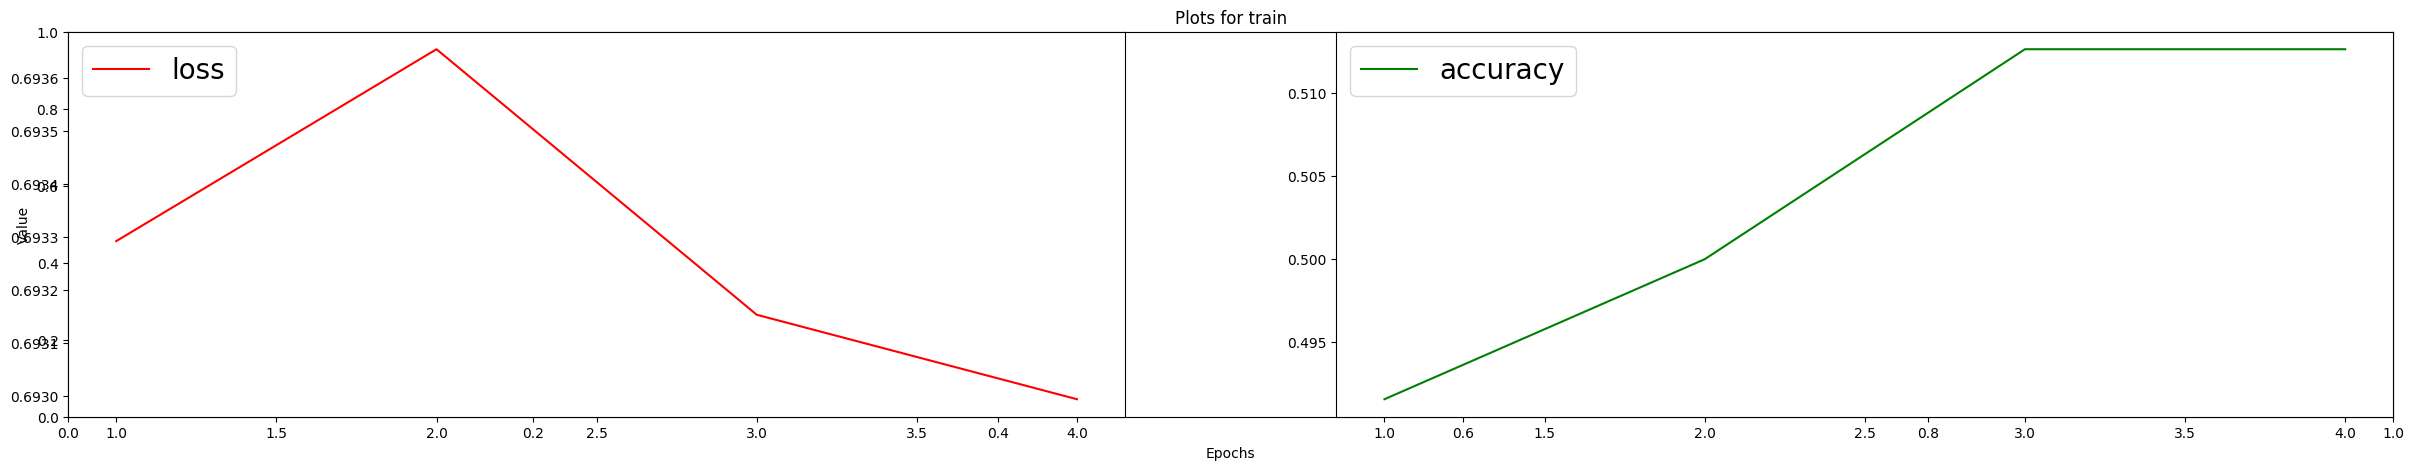

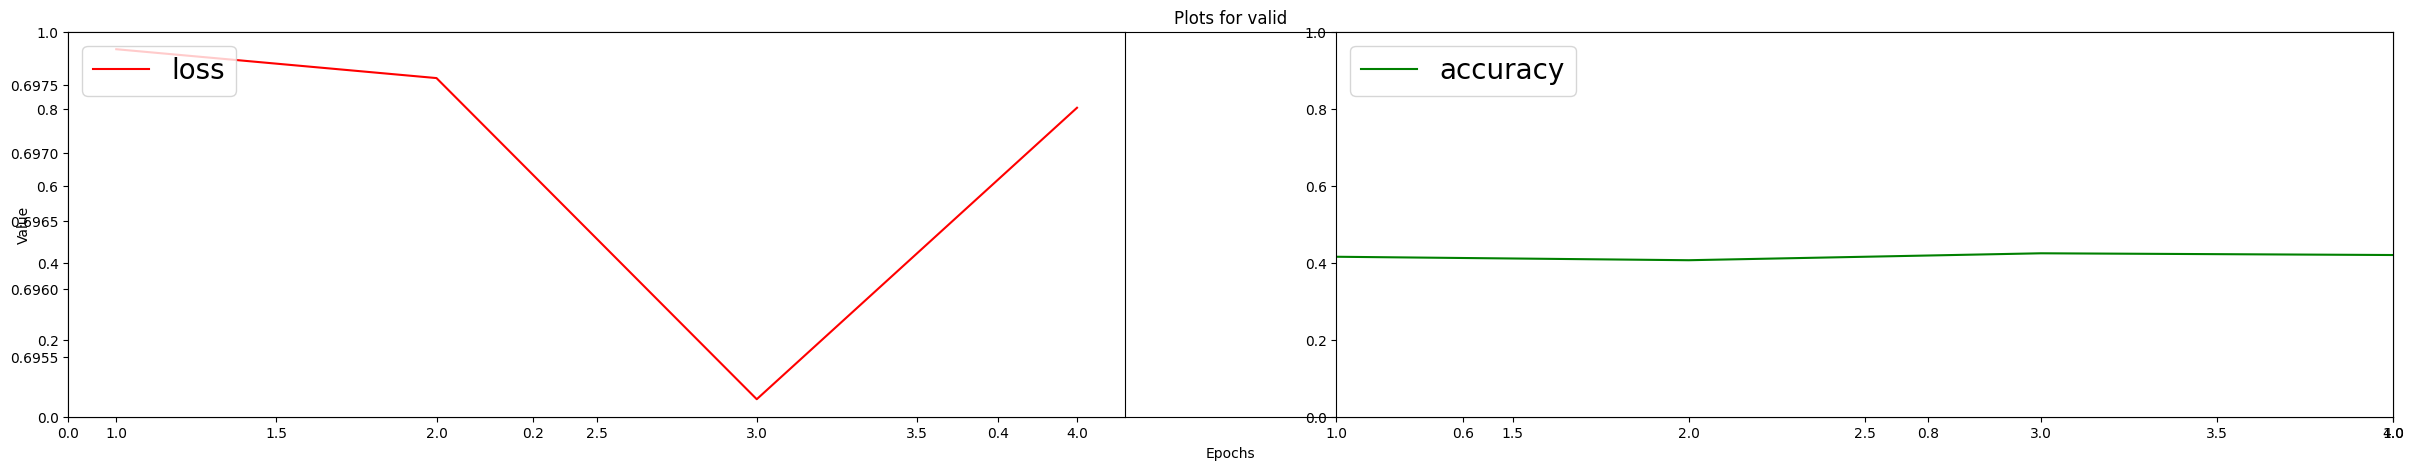

In [84]:
lr = 0.005
epochs = 4
batch_size = 50

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.51484614610672, train loss : 0.6927748322486877
Epoch : 1, val_accuracy : 0.41062498092651367, val_loss : 0.6982581615447998
Epoch : 2, train accuracy : 0.5162692070007324, train loss : 0.6927587985992432
Epoch : 2, val_accuracy : 0.4762499928474426, val_loss : 0.6946885585784912
Epoch : 3, train accuracy : 0.5162692070007324, train loss : 0.6926119327545166
Epoch : 3, val_accuracy : 0.41062498092651367, val_loss : 0.6989879012107849
Epoch : 4, train accuracy : 0.5205384492874146, train loss : 0.6923601031303406
Epoch : 4, val_accuracy : 0.42374998331069946, val_loss : 0.6989437341690063


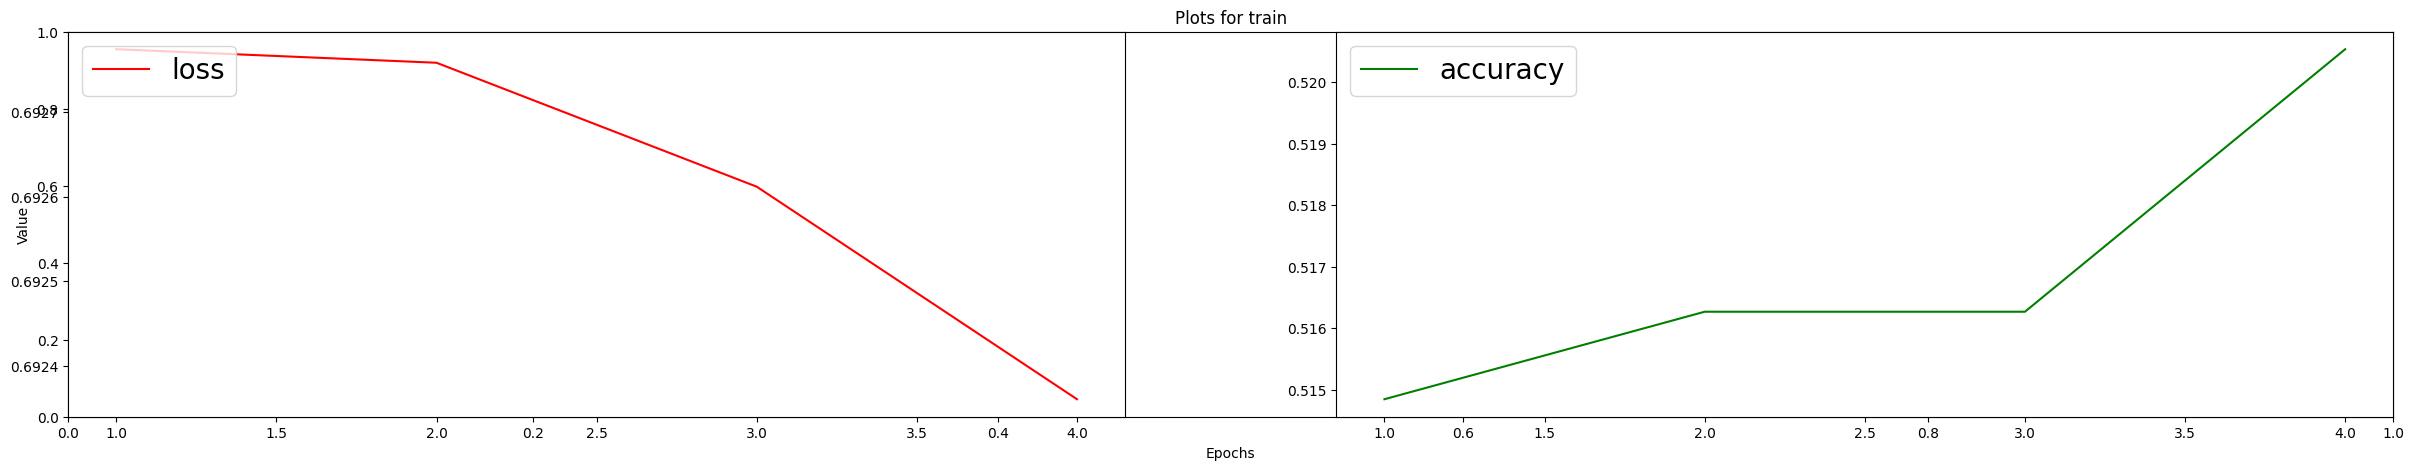

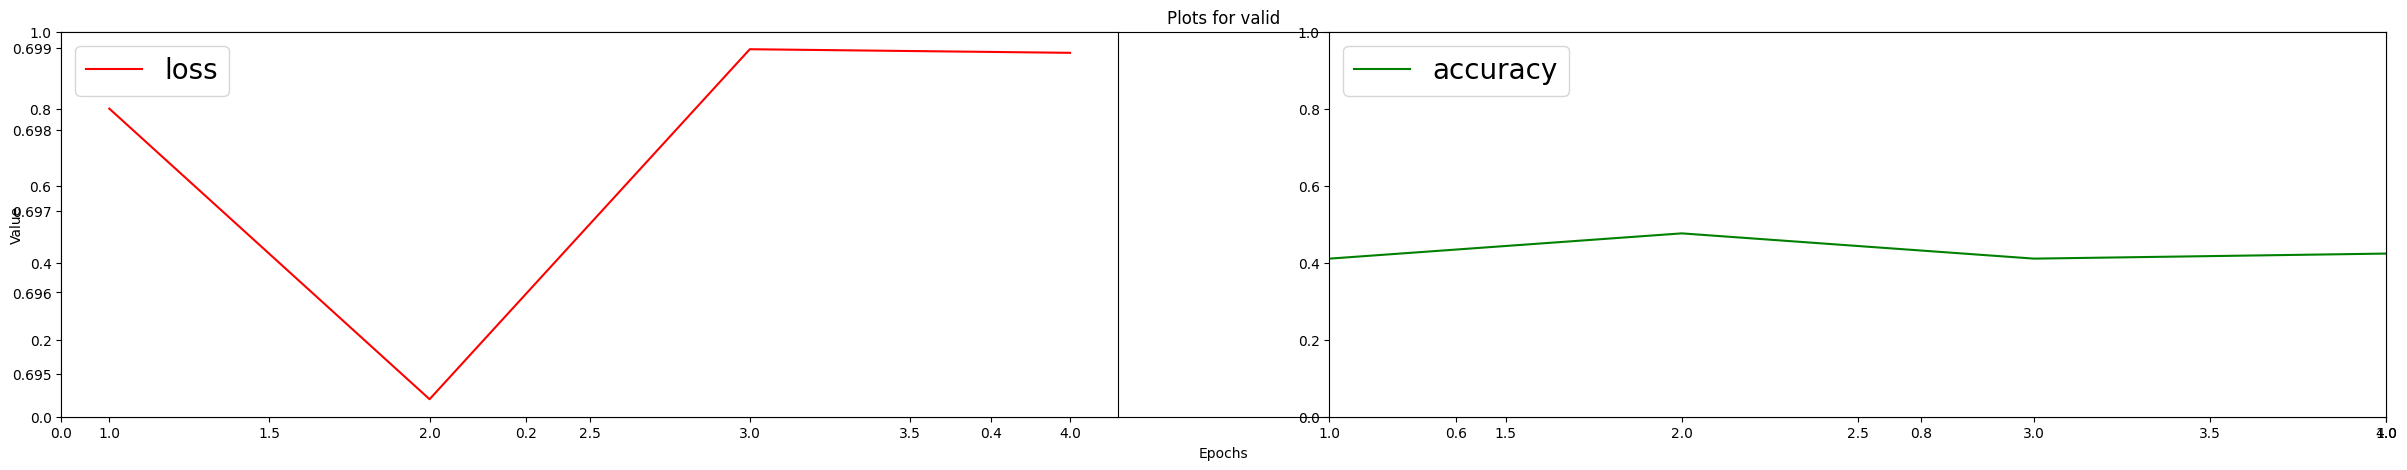

In [85]:
lr = 0.005
epochs = 4
batch_size = 200

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

train_loop(train_loader, val_loader, epochs, lr)

Epoch : 1, train accuracy : 0.8819615244865417, train loss : 0.26130688190460205
Epoch : 1, val_accuracy : 0.9025000333786011, val_loss : 0.3398377597332001
Epoch : 2, train accuracy : 0.8826153874397278, train loss : 0.2825232744216919
Epoch : 2, val_accuracy : 0.8725000023841858, val_loss : 0.258648544549942
Epoch : 3, train accuracy : 0.8813846111297607, train loss : 0.26472800970077515
Epoch : 3, val_accuracy : 0.9162499904632568, val_loss : 0.22364702820777893
Epoch : 4, train accuracy : 0.8906154036521912, train loss : 0.24816879630088806
Epoch : 4, val_accuracy : 0.934374988079071, val_loss : 0.2141772210597992
Epoch : 5, train accuracy : 0.8830385208129883, train loss : 0.28084704279899597
Epoch : 5, val_accuracy : 0.9037500023841858, val_loss : 0.2681455612182617
Epoch : 6, train accuracy : 0.8835384845733643, train loss : 0.2791515588760376
Epoch : 6, val_accuracy : 0.9243749976158142, val_loss : 0.23131123185157776
Epoch : 7, train accuracy : 0.8909615278244019, train loss :

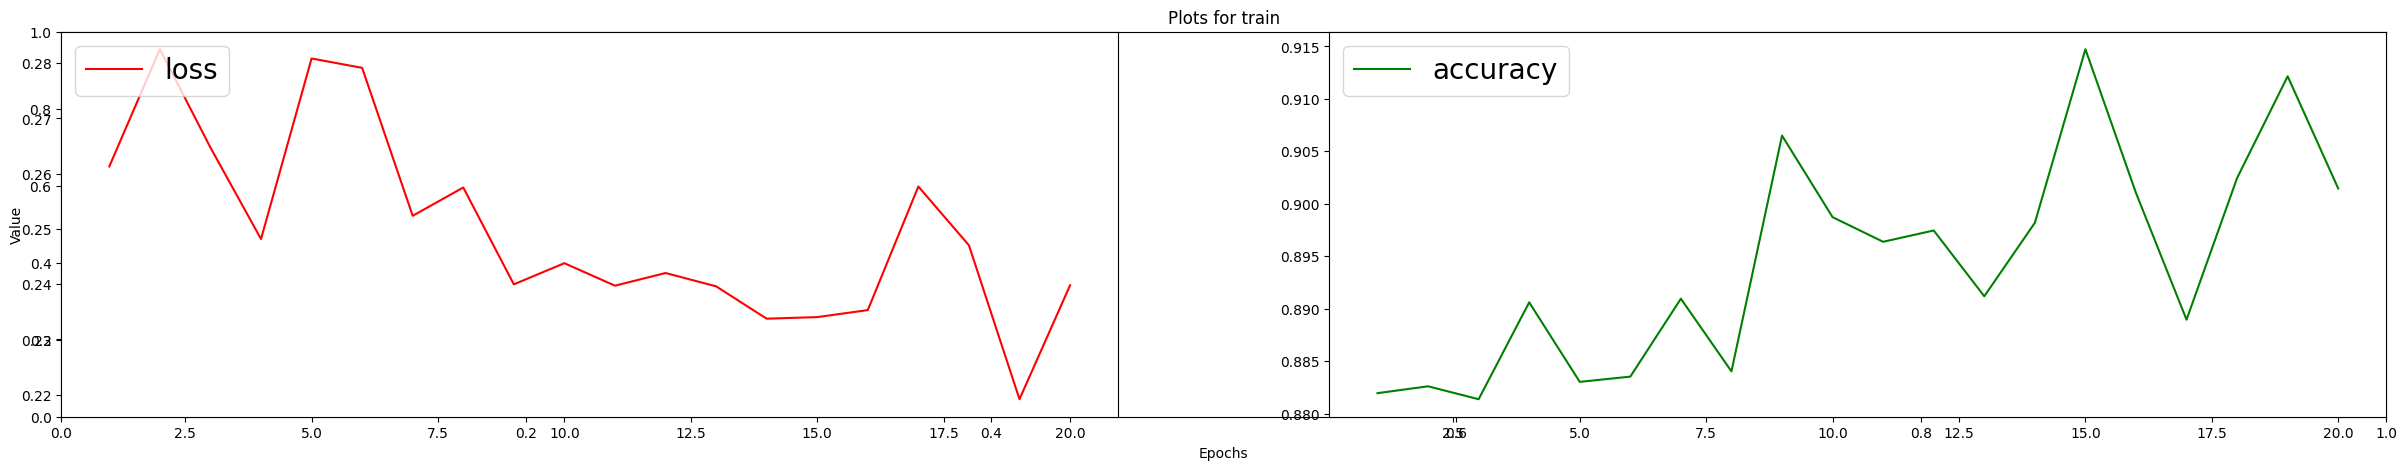

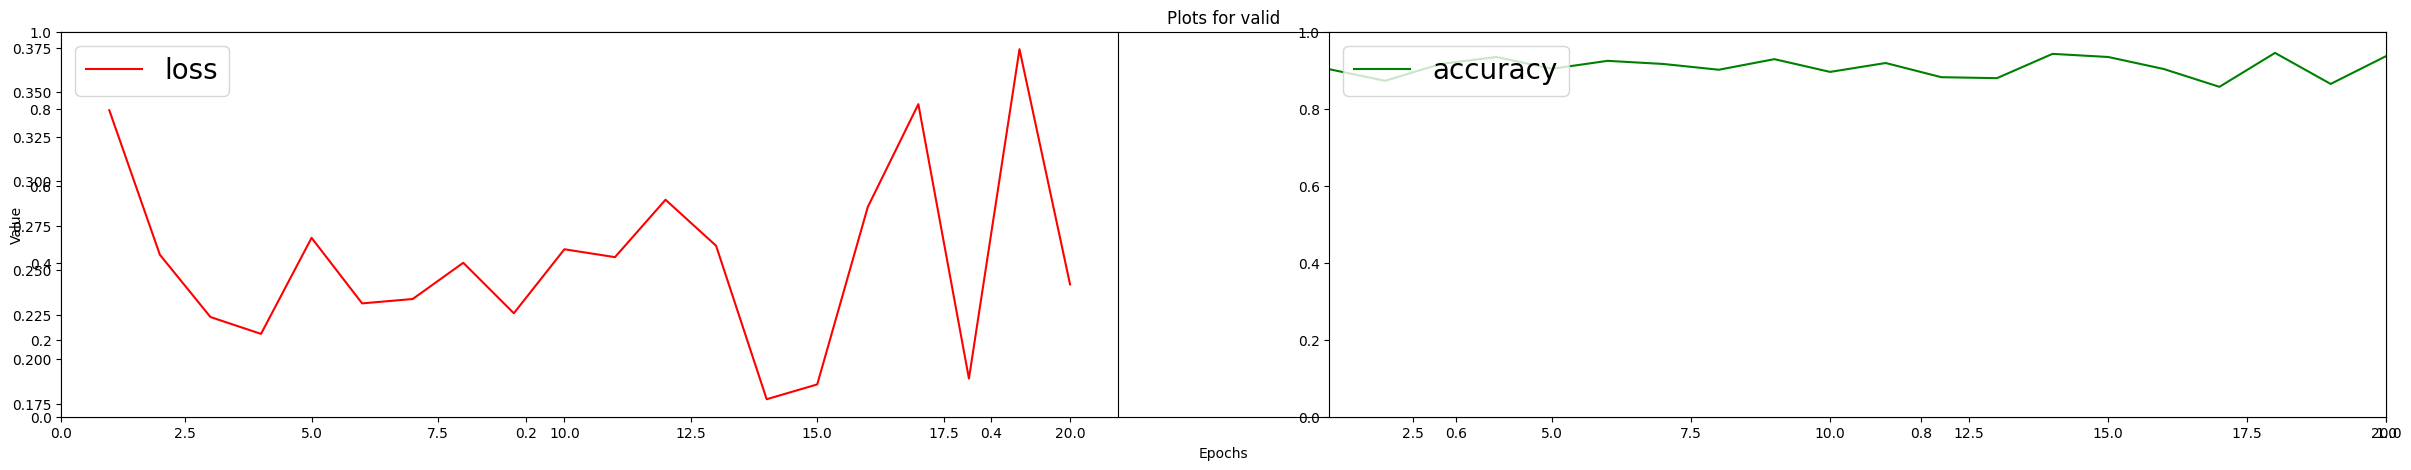

In [9]:
lr = 0.0005
epochs = 20
batch_size = 200

train_loader = DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

train_loop(train_loader, val_loader, epochs, lr)

In [10]:
probs = []
model.eval()
indexs = []

with torch.no_grad():
    for data, fileid, i in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim = 1)[:, 1].tolist()
        probs += list(zip(i, preds_list))

probs.sort()
print(probs)


[(tensor(110), 0.999300479888916), (tensor(121), 0.11085589975118637), (tensor(124), 0.0012095740530639887), (tensor(165), 0.5606768131256104), (tensor(177), 0.9994351267814636), (tensor(220), 0.7773619890213013), (tensor(275), 0.5826640725135803), (tensor(332), 0.9218677282333374), (tensor(361), 0.8891032934188843), (tensor(377), 0.8985542058944702), (tensor(402), 0.8058950304985046), (tensor(437), 0.9736440181732178), (tensor(522), 0.2871653437614441), (tensor(523), 0.42783865332603455), (tensor(599), 0.01062066201120615), (tensor(600), 0.9877756834030151), (tensor(633), 0.9984410405158997), (tensor(671), 0.6169588565826416), (tensor(728), 0.7248840928077698), (tensor(764), 0.9975415468215942), (tensor(776), 0.0026040098164230585), (tensor(941), 0.997610330581665), (tensor(1055), 0.9990091323852539), (tensor(1066), 8.745477680349723e-05), (tensor(1222), 0.15543194115161896), (tensor(1246), 0.9839892983436584), (tensor(1262), 0.00034073993447236717), (tensor(1282), 0.05812620744109154

               id     label
0     tensor(110)  0.999300
1     tensor(121)  0.110856
2     tensor(124)  0.001210
3     tensor(165)  0.560677
4     tensor(177)  0.999435
..            ...       ...
227  tensor(9889)  0.803407
228  tensor(9894)  0.904670
229  tensor(9924)  0.278378
230  tensor(9939)  0.004266
231  tensor(9946)  0.101134

[232 rows x 2 columns]


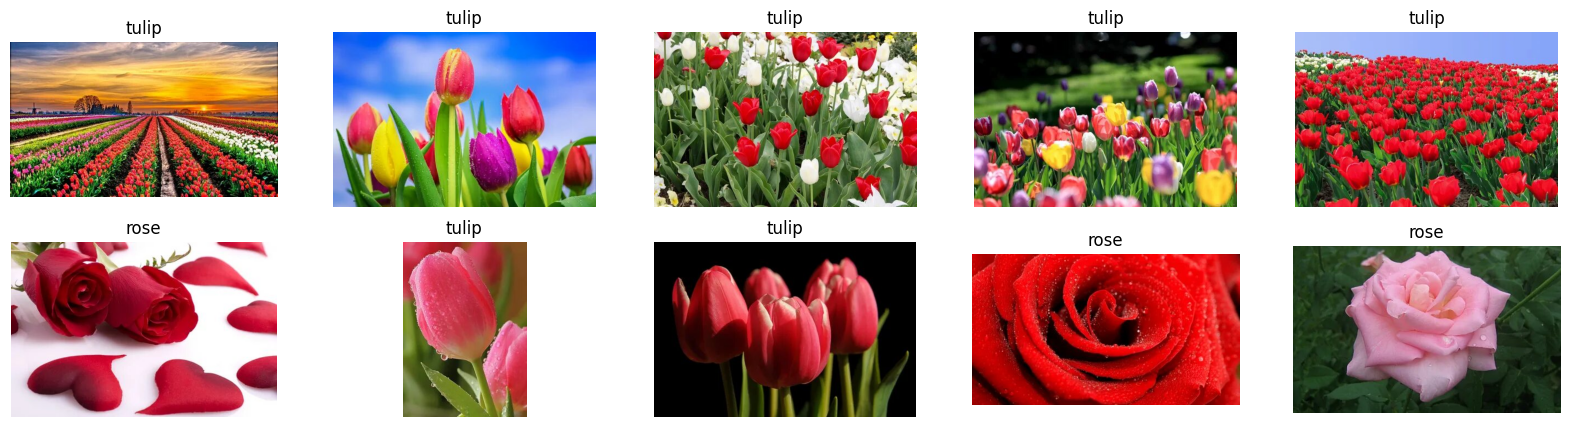

In [12]:
idx = list(map(lambda x: x[0], probs))
prob = list(map(lambda x: x[1], probs))

submission = pd.DataFrame({'id':idx,'label':prob})

print(submission)

submission.to_csv('result.csv', index = False)

id_list = []
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(2, 5, figsize = (20, 5), facecolor = 'w')

for ax in axes.ravel():
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    
    if label > 0.5:
        label = 1
        name = "tulip"
    else:
        label = 0
        name = "rose"
    
    if os.path.isfile(f"{directory}\\rose.{i}.jpeg"):
        img_path = f"{directory}\\rose.{i}.jpeg"
    else:
        img_path = f"{directory}\\tulip.{i}.jpeg"    
    
    ax.axis('off')
    ax.tick_params(axis = 'both', left = False, top = False, right = False, bottom = False,
                    labelleft = False, labeltop = False, labelright = False, labelbottom = False)
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

plt.show()